### Regulation kinetics of Na+-Ca2+ exchange current in guinea-pig ventricular myocytes

#### Import libraries

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [8]:
# function that returns dy/dt
def model(y,t,k):
    
    '''y[0] = FE1,
       y[1] = FI1,
       y[2] = FI2,
       y[3]=FE2'''
    
    dy1dt = (k["k2"]+k["k3"]) + \
            y[1]*(k["beta1"]-k['k2']-k['k3']) +\
            y[2]*(k["beta2"]-k['k2']+k['k3']) - \
            y[0]*(k["k1"]+k['k2']+k['k3']+k["k4"]+k["alpha1"]+k["alpha2"])
    
    dy2dt = y[0]*k["alpha1"] - y[1]*k["beta1"]
    dy3dt = y[0]*k["alpha2"] - y[2]*k["beta2"]
    
    dydt = [dy1dt,dy2dt,dy3dt]

    return dydt

#### Define Constant

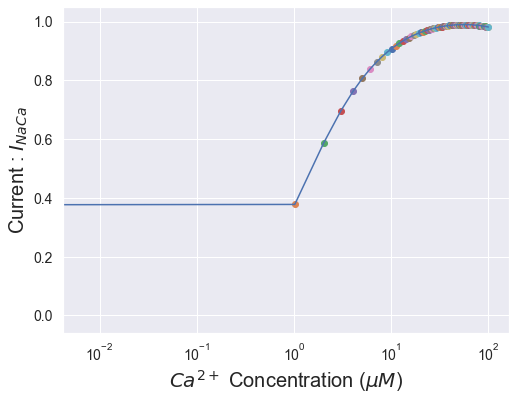

In [13]:
pt = 0
PT = []
plt.figure(figsize = [8,6])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#CAI = [0.01e-6,0.1e-6,1e-6]
CAI = list(np.linspace(0.01e-6,100e-6,100))

#CAI = [0.01e-6,0.1e-6,1e-6,10e-6,100e-6]
II = []
CA = []
Data = []
tt = 0 
for Cai in CAI:
    Nai = 100*1e-3
    Nao = 0*1e-3
    Cao = 5*1e-3
    #Ca = 2e-3
    K_ci = 0.01*1e-3
    K_4ni = 8*1e-3
    K_3ni = 9*1e-3
    K_2ni = 9*1e-3
    K_1ni = 700*1e-3
    asym = 80*1e-3 
    V_m = 0*1e-3
    kvm = np.exp(2.0*V_m/53.08)
    K_Ca_act = 0.004*1e-3

    alpha1_Ca_on = 2.0
    alpha1_Ca_off = 1.5
    beta1_Ca_on = 1.2
    beta1_Ca_off = 0.0005

    alpha2_Ca_on = 0.03
    alpha2_Ca_off = 10
    beta2_Ca_on = 90
    beta2_Ca_off = 0.1


    D_i = (Nai**4)*K_ci +\
      (Nai**3)*K_ci*K_4ni +\
      (Nai**2)*K_ci*K_4ni*K_3ni + \
      (Nai**1)*K_ci*K_4ni*K_3ni*K_2ni + \
      K_ci*K_4ni*K_3ni*K_2ni*K_1ni + \
      Cai*K_4ni*K_3ni*K_2ni*K_1ni

    #print("D_i: ",D_i)
    #print("---------------")

    F_E14Na = (Nai**4)*K_ci/D_i
    F_E1Ca = Cai*K_1ni*K_2ni*K_3ni*K_4ni/D_i
    

    K_1no = (asym**0.25)*K_1ni
    K_2no = (asym**0.25)*K_2ni
    K_3no = (asym**0.25)*K_3ni
    K_4no = (asym**0.25)*K_4ni
    K_co =  (asym**0.25)*K_ci
    
    F_E24Na = (Nai**4)*K_co/D_i
    F_E2Ca = Cai*K_1no*K_2no*K_3no*K_4no/D_i

    k1 = F_E14Na*1000*kvm
    k2 = F_E24Na*1000/kvm
    k3 = F_E2Ca*1000
    k4 = F_E1Ca*1000

    #print("[k1,k2,k3,k4]: ", [k1,k2,k3,k4])
    #print("---------------")

    F_Ca_act = Cai/(Cai+K_Ca_act)
    alpha1 = F_E14Na*((F_Ca_act*alpha1_Ca_on)\
            +(1-F_Ca_act)*alpha1_Ca_off)
    beta1 = F_Ca_act*beta1_Ca_on \
            + (1-F_Ca_act)*beta1_Ca_off
    alpha2 = F_Ca_act*alpha2_Ca_on \
            + (1-F_Ca_act)*alpha2_Ca_off
    beta2 = F_Ca_act*beta2_Ca_on \
            + (1-F_Ca_act)*beta2_Ca_off

    k = {"alpha1":alpha1,"beta1":beta1,\
        "alpha2":alpha2,"beta2":beta2,\
        "k1":k1,"k2":k2,"k3":k3,"k4":k4}

    #print("k: ",k)
    #print("------------------")
    
    N = 1
    T = 50

    # initial condition
    y0 = [1,0,0]


    # time points
    t = np.linspace(0,T)


    '''solve ODEs'''
    y = odeint(model,y0,t,args=(k,))


    y1 = np.empty_like(t)
    y2 = np.empty_like(t)
    y3 = np.empty_like(t)
    y4 = np.empty_like(t)
    I  = np.empty_like(t)

    for i in range(len(t)):
        y1[i] = y[i][0]
        y2[i] = y[i][1]
        y3[i] = y[i][2]
        y4[i] = 1 - y1[i]-y2[i]-y3[i]
        
        I[i] = y1[i]*k1 - y3[i]*k2

    #print("I : ", I[len(t) -1])
    
    if tt>0:
        Data.append({"Ca":Cai*1e6,"I":I[len(t) -1]/200})
        II.append(I[len(t) -1]/200)
        CA.append((Cai*1e6))
        PT.append(pt)
        pt = pt+1
        plt.scatter(Cai*1e6,I[len(t) -1]/200)
    else: 
        Data.append({"Ca":0,"I":0})
        plt.scatter(0,0)
        CA.append(0)
        II.append(0)
    
    tt = tt+1
plt.semilogx(CA,II)
plt.xlabel("$Ca^{2+}$ Concentration ($\mu M$)", fontsize =20)
plt.ylabel("Current : $I_{NaCa}$", fontsize =20)
plt.show()

In [10]:
import pandas as pd
DF = pd.DataFrame(Data)
DF.to_csv("naca.csv")

In [11]:
DF['II'] = DF['I'].apply(lambda x: np.log(x))

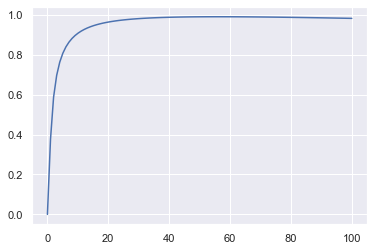

In [12]:
plt.plot(DF['Ca'],DF['I'])

---------